In [1]:
from torchvision import models, transforms
from torchsummary import summary
import torch
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.dirname(current_dir))

from lib.src import *
from lib.utils import *

2024-12-13 11:57:21.415248: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 11:57:21.426971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734087441.442967    6198 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734087441.448091    6198 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 11:57:21.462981: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
model = models.resnet50(pretrained=True)
class_names = np.loadtxt('imagenet_classes.txt', str, delimiter='\t')

/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


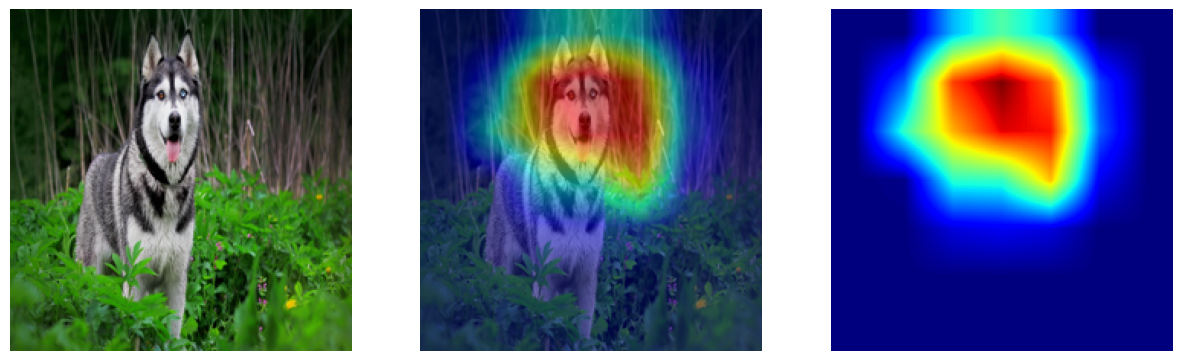

In [3]:
img = get_image_torch('images/husky.jpg', 224, 224)
cam_husky_our = get_xgradcam(img, model, model.layer4[-1].conv3)
overlay_plot_torch(img, cam_husky_our, 0.5, 'images_prezentacja/xgradcam_husky.png')

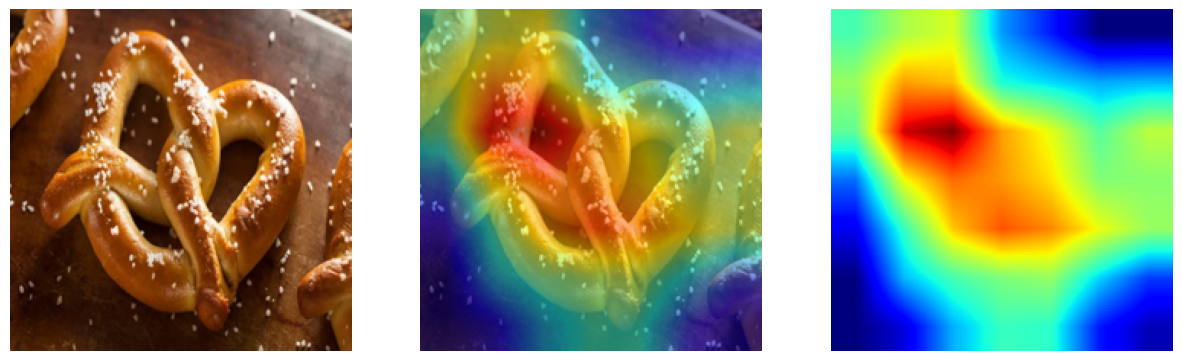

In [4]:
img = get_image_torch('images/precelek.jpg', 224, 224)
cam_pretzel_our = get_xgradcam(img, model, model.layer4[-1].conv3)
overlay_plot_torch(img, cam_pretzel_our, 0.5, 'images_prezentacja/xgradcam_precel.png')

In [5]:
from pytorch_grad_cam import GradCAM, HiResCAM, AblationCAM, ScoreCAM, GradCAMPlusPlus, XGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

In [6]:
model = resnet50(pretrained=True)
target_layers = [model.layer4[-1].conv3]

/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


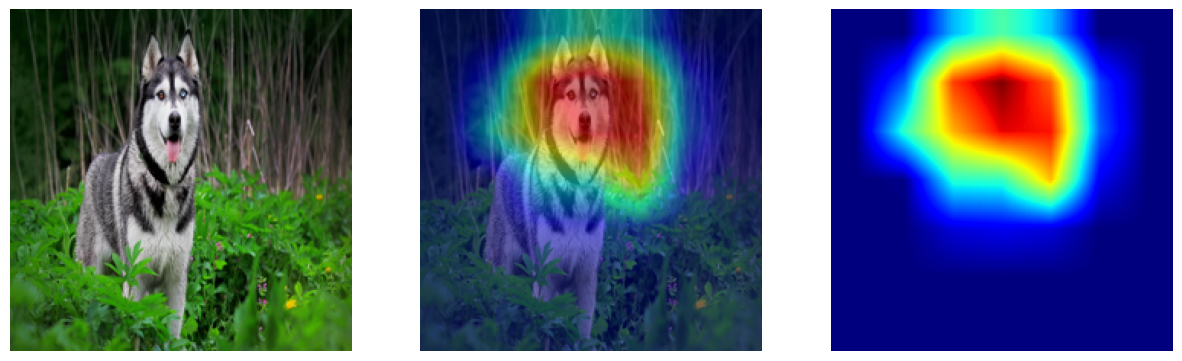

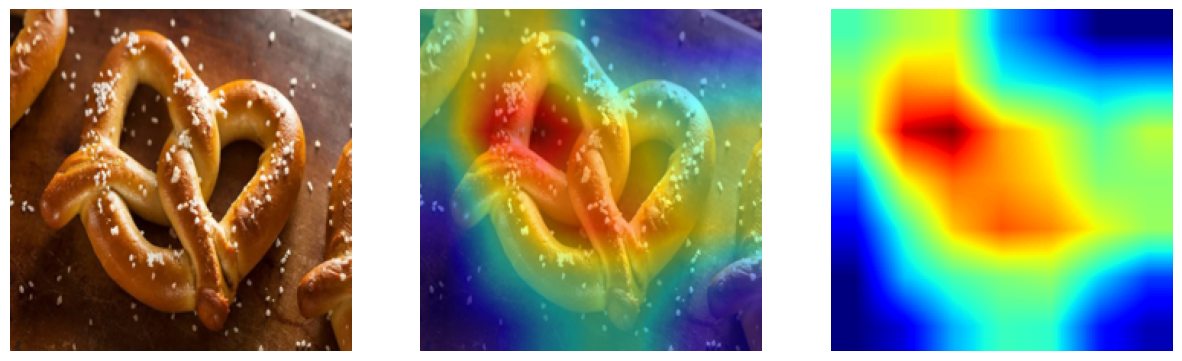

In [7]:
input_tensor = get_image_torch('images/husky.jpg', 224, 224).unsqueeze(0)
targets = [ClassifierOutputTarget(250)]

with XGradCAM(model=model, target_layers=target_layers) as cam:
  cam_husky_lib = cam(input_tensor=input_tensor, targets=targets).squeeze(0)
overlay_plot_torch(input_tensor.squeeze(), cam_husky_lib, 0.5, 'images_prezentacja/xgradcam_husky_lib.png')

input_tensor = get_image_torch('images/precelek.jpg', 224, 224).unsqueeze(0)
targets = [ClassifierOutputTarget(932)]

with XGradCAM(model=model, target_layers=target_layers) as cam:
  cam_pretzel_lib = cam(input_tensor=input_tensor, targets=targets).squeeze(0)
overlay_plot_torch(input_tensor.squeeze(), cam_pretzel_lib, 0.5, 'images_prezentacja/xgradcam_precel_lib.png')

In [8]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics.pairwise import cosine_similarity

def print_metrics(our, lib, x, y):
    our = our.copy()
    our = cv2.resize(our, (x, y))

    print(f'MSE: {np.mean((our - lib) ** 2)}')
    print(f'MAE: {np.mean(np.abs(our - lib))}')
    print(f'SSIM: {ssim(our, lib, data_range=1)}')
    print(f'Cosine similarity: {cosine_similarity(our.reshape(1, -1), lib.reshape(1, -1))}')

In [9]:
print_metrics(cam_husky_our, cam_husky_lib, 224, 224)

MSE: 9.212932354785153e-07
MAE: 0.0005840720259584486
SSIM: 0.9998777677463307
Cosine similarity: [[0.9999972]]


In [10]:
print_metrics(cam_pretzel_our, cam_pretzel_lib, 224, 224)

MSE: 4.770157829625532e-06
MAE: 0.0019305436871945858
SSIM: 0.9999885204807896
Cosine similarity: [[0.99999976]]
